In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from sklearn.cluster import KMeans

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

df = pd.read_csv("used_cars_data.csv", nrows=100000, low_memory=False)

### Valitaan datasta tarvittavat sarakkeet kun selvitetään myyntialueen vaikutusta ajoneuvon ikään, tyyppiin ja hintaan.

In [2]:
selected_columns = ["city", "dealer_zip", "body_type", "make_name", "model_name", "year", "price"]
df = df[selected_columns]

df.head(10)

,city,dealer_zip,body_type,make_name,model_name,year,price
0,Bayamon,960,SUV / Crossover,Jeep,Renegade,2019,23141.0
1,San Juan,922,SUV / Crossover,Land Rover,Discovery Sport,2020,46500.0
2,Guaynabo,969,Sedan,Subaru,WRX STI,2016,46995.0
3,San Juan,922,SUV / Crossover,Land Rover,Discovery,2020,67430.0
4,San Juan,922,SUV / Crossover,Land Rover,Discovery Sport,2020,48880.0
5,San Juan,922,SUV / Crossover,Land Rover,Range Rover Velar,2020,66903.0
6,Bayamon,960,Sedan,Mazda,MAZDA3,2019,23695.0
7,San Juan,922,SUV / Crossover,Land Rover,Range Rover Velar,2020,68520.0
8,San Juan,922,SUV / Crossover,Land Rover,Discovery Sport,2020,51245.0
9,San Juan,922,SUV / Crossover,Land Rover,Range Rover Evoque,2020,84399.0


### Lisätään dataframeen alueellinen sarake postinumeroiden mukaan

In [3]:
df["dealer_zip"] = df["dealer_zip"].apply(lambda x: int(str(x)[0]))

zip_areas = {
    1: "Mid-Atlantic",
    2: "East South Central",
    3: "East South Central",
    4: "East North Central",
    5: "Mid West",
    6: "West North Central",
    7: "West South Central",
    8: "Mountain",
    9: "Pacific",
}

df["area"] = df["dealer_zip"].map(zip_areas)

df.head(5)

,city,dealer_zip,body_type,make_name,model_name,year,price,area
0,Bayamon,9,SUV / Crossover,Jeep,Renegade,2019,23141.0,Pacific
1,San Juan,9,SUV / Crossover,Land Rover,Discovery Sport,2020,46500.0,Pacific
2,Guaynabo,9,Sedan,Subaru,WRX STI,2016,46995.0,Pacific
3,San Juan,9,SUV / Crossover,Land Rover,Discovery,2020,67430.0,Pacific
4,San Juan,9,SUV / Crossover,Land Rover,Discovery Sport,2020,48880.0,Pacific


<center><h3> Tässä näkyvät alueet, joihin data on jaettu postinumeron mukaan </h3></center>

![USA_9_Divisions](kuvat/USA_9_Divisions.PNG)
![1-digit_zip_code](kuvat/1-digit_zip_code.PNG)

### Katsotaan kaupunki kohtaisesti suosituin malli, merkki, sekä keskiarvo hinta ja ikä

In [4]:
# Etsitään suosituin automerkki ja automalli aluille
most_popular_car = df.groupby("area")[["make_name", "model_name", "body_type"]].agg(lambda x: x.value_counts().idxmax()).reset_index()
most_popular_car.columns = ["Alue", "Suosituin merkki", "Suosituin malli", "Suosituin korimalli"]

# Lasketaan keskimääräinen hinta alueille
average_price = df.groupby("area")["price"].mean().reset_index()
average_price.columns = ["Alue", "Keskimääräinen hinta"]

# Lasketaan keskimääräinen vuosimalli aluille
average_year = df.groupby("area")["year"].mean().reset_index()
average_year.columns = ["Alue", "Keskimääräinen vuosimalli"]

# Yhdistä kaikki tiedot yhteen DataFrameen
most_popular_car = most_popular_car.merge(average_price, on="Alue").merge(average_year, on="Alue")

# Pyöristetään
most_popular_car["Keskimääräinen vuosimalli"] = most_popular_car["Keskimääräinen vuosimalli"].round(0).astype(int)
most_popular_car["Keskimääräinen hinta"] = most_popular_car["Keskimääräinen hinta"].round(0).astype(int)

most_popular_car

,Alue,Suosituin merkki,Suosituin malli,Suosituin korimalli,Keskimääräinen hinta,Keskimääräinen vuosimalli
0,East North Central,Ford,Fusion,SUV / Crossover,31488,2018
1,East South Central,Honda,CR-V,SUV / Crossover,30722,2018
2,Mid West,Volkswagen,Jetta,SUV / Crossover,28957,2018
3,Mid-Atlantic,Toyota,Equinox,SUV / Crossover,31633,2018
4,Mountain,Ford,F-150,SUV / Crossover,32972,2018
5,Pacific,Land Rover,Discovery Sport,SUV / Crossover,61590,2020
6,West North Central,Ford,Tucson,SUV / Crossover,26931,2017
7,West South Central,Ford,Grand Cherokee,SUV / Crossover,29063,2016


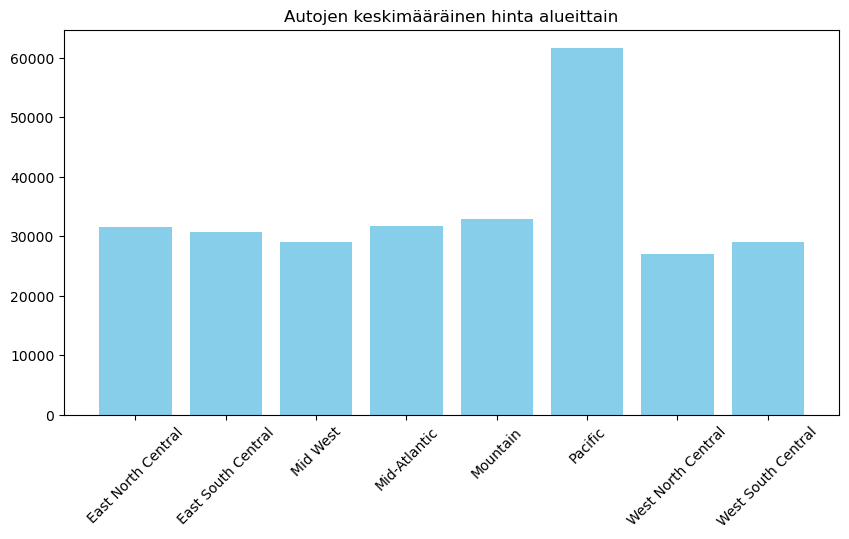

In [5]:
# Luodaan pylväsdiagrammi
plt.figure(figsize=(10, 5))
plt.bar(most_popular_car["Alue"], most_popular_car["Keskimääräinen hinta"], color='skyblue')
plt.title("Autojen keskimääräinen hinta alueittain")
plt.xticks(rotation=45) 
plt.show()

### Katsotaan jokaisen alueen suosituinta automerkkiä ja kuinka paljon niitä on

In [6]:
# Ryhmitellään data alueen ja automerkin perusteella ja lasketaan kunkin alueen suosituimpien merkkien lukumäärä
suosituimmat_merkit_määrä = df.groupby(["area", "make_name"])["make_name"].count().reset_index(name="Suosituimpien merkkien määrä")

# Lisätään kunkin alueen autojen kokonaismäärä
autojen_kokonaismäärä = df.groupby("area")["make_name"].count().reset_index(name="Autojen kokonaismäärä")

# Yhdistetään suosituimmat merkit ja autojen kokonaismäärä alueen perusteella
suosituimmat_alueittain = suosituimmat_merkit_määrä.groupby("area").apply(lambda x: x.nlargest(1, columns="Suosituimpien merkkien määrä")).reset_index(drop=True)
suosituimmat_alueittain = suosituimmat_alueittain.merge(autojen_kokonaismäärä, on="area", how="left")

# Tulostetaan suosituimmat merkit alueittain
suosituimmat_alueittain

,area,make_name,Suosituimpien merkkien määrä,Autojen kokonaismäärä
0,East North Central,Ford,4918,16685
1,East South Central,Honda,1249,10235
2,Mid West,Volkswagen,24,63
3,Mid-Atlantic,Toyota,3722,33910
4,Mountain,Ford,1059,6409
5,Pacific,Land Rover,66,113
6,West North Central,Ford,2004,13907
7,West South Central,Ford,2637,18678


### Ympyrädiagrammi jokaisen alueen osuus autojen kokonaismäärästä

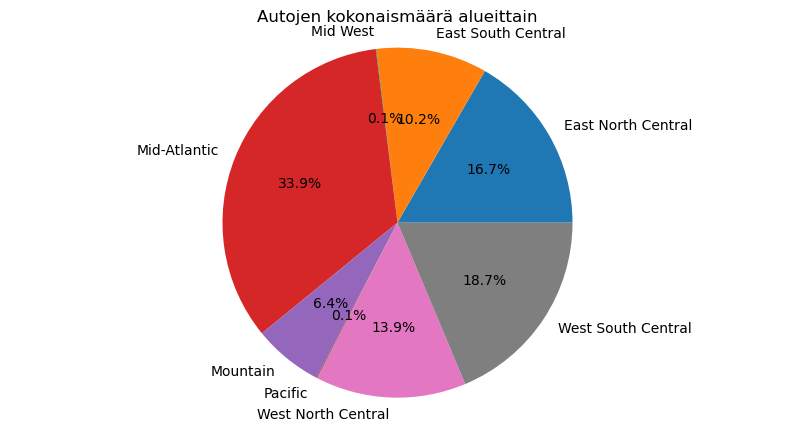

In [7]:
# Ryhmitellään data alueen mukaan ja lasketaan autojen kokonaismäärä kullekin alueelle
autojen_kokonaismäärä = df.groupby("area")["make_name"].count().reset_index(name="Autojen kokonaismäärä")

# Luo ympyrädiagrammi
plt.figure(figsize=(10, 5))
plt.pie(autojen_kokonaismäärä["Autojen kokonaismäärä"], labels=autojen_kokonaismäärä["area"], autopct="%1.1f%%")
plt.title("Autojen kokonaismäärä alueittain")
plt.axis("equal")  # Tehdään ympyrädiagrammi pyöreäksi

plt.show()

### Alueiden viiden suurimman merkin osuudet 

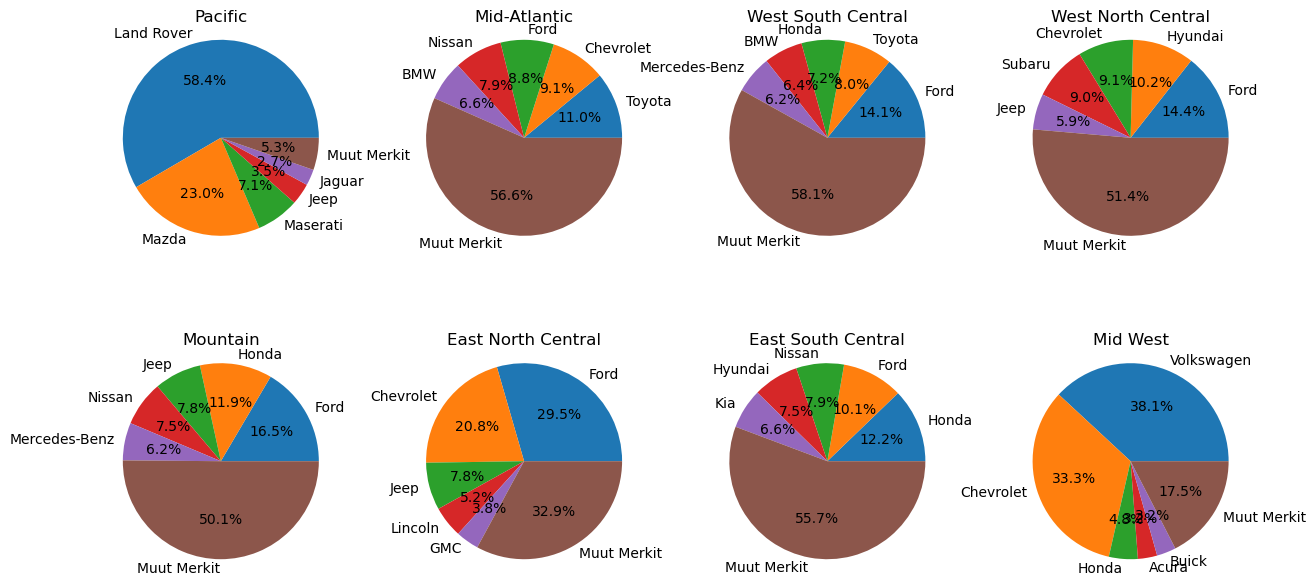

In [8]:
# Lasketaan automerkkien määrä alueittain ja tallennetaan se DataFrameen
merkkien_maarat_alueittain = df.groupby(["area", "make_name"])["make_name"].count().reset_index(name="Merkkien määrä")

# Luo alueiden omat ruudukot yksittäisiä ympyrädiagrammeja varten
fig, axs = plt.subplots(2, 4, figsize=(15, 7))
fig.subplots_adjust(hspace=0.5)

# Käydään läpi alueet
for i, alue in enumerate(df["area"].unique()):
    # Valitaan data vain kyseiseltä alueelta
    suosituimmat_alueella = merkkien_maarat_alueittain[merkkien_maarat_alueittain["area"] == alue]

    # Järjestetään data "Merkkien määrä" -määrän perusteella laskevaan järjestykseen
    suosituimmat_alueella = suosituimmat_alueella.sort_values(by="Merkkien määrä", ascending=False)

    # Säilytetään viisi suosituinta automerkkiä ja ryhmitellään loput "Muut Merkit" -kategoriaksi
    top_5 = suosituimmat_alueella.head(5)
    other = suosituimmat_alueella.iloc[5:]
    
    # Luodaan uusi rivi "Muut Merkit" -kategoriaksi ja lasketaan näiden merkkien yhteismäärä
    other_row = pd.DataFrame({"make_name": ["Muut Merkit"], "Merkkien määrä": [other["Merkkien määrä"].sum()]})

    # Yhdistetään viisi suosituinta merkkiä ja "Muut Merkit" -rivit
    yhdistetty_data = pd.concat([top_5, other_row])

    # Luo ympyrädiagrammi valitulle datalle
    axs[i // 4, i % 4].pie(
        yhdistetty_data["Merkkien määrä"],
        labels=yhdistetty_data["make_name"],
        autopct="%1.1f%%"
    )
    axs[i // 4, i % 4].set_title(alue)
    axs[i // 4, i % 4].axis("equal")

# Näytä ympyrädiagrammit
plt.show()


### Vertaillaan Ford merkkisten autojen hintoja alueittain

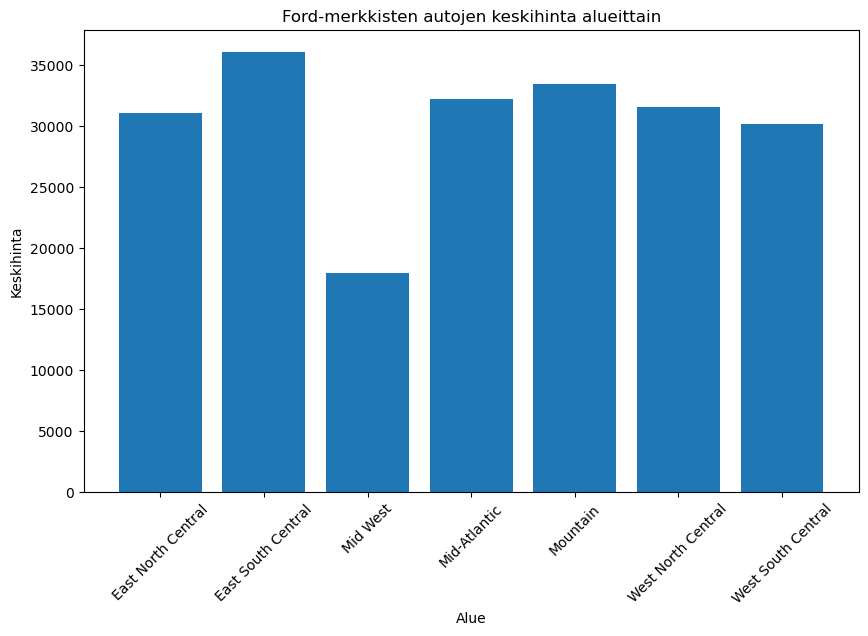

In [9]:
# Lasketaan Ford-merkkisten autojen keskihinnat eri alueilla ja tallennetaan ne DataFrameen
ford_keskihinnat_alueittain = df[df["make_name"] == "Ford"].groupby("area")["price"].mean().reset_index()

# Luo pylväskaavio Ford-merkkisten autojen keskihinnoista eri alueilla
plt.figure(figsize=(10, 6))
plt.bar(ford_keskihinnat_alueittain["area"], ford_keskihinnat_alueittain["price"])
plt.xlabel("Alue")
plt.ylabel("Keskihinta")
plt.title("Ford-merkkisten autojen keskihinta alueittain")
plt.xticks(rotation=45)
plt.show()